In [35]:
# Imports

import torchaudio
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os, sys
import pandas as pd

import re

In [2]:
from pathlib import Path
from glob import glob
# Files
ASSET_FOLDER = Path("..") / ".." / "assets"
DATASET_FOLDER = Path(glob(str(ASSET_FOLDER / "*dataset*"))[0]) # using indexing so I dont have to specify the folder name

TRAINING_DATA_FOLDER = DATASET_FOLDER / "training_data"
file = TRAINING_DATA_FOLDER  / "2530_AV.wav"

assert file.is_file() , f"File does not exist {file}"

# Task


### For Exploratory Data Analysis (EDA), you can do the followings:


- Plot the audio wave-form for couple of subjects

- How many age groups do we have in the dataset? How many unique type of disease do exist?

- How many types of channels do we have? Which one is common among all measurements? 

- Obtain the percentage of each channel across all recordings.

- Obtain the correlation among different channels for a few subjects from different age groups

- Explore Short-Time-Frequency-Transform (STFT) and Mel Spectrogram: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53. Apply these two transformations for some subjects




### Descriptive Statistics:

###### Calculate mean, median, and standard deviation of age and recording duration.


- Visualization: 
    - Create histograms and box plots for age and recording duration.

- Cardiac Murmurs Analysis:
    - Distribution across age groups and auscultation locations.

- Annotations Analysis:
    - Explore timing, shape, pitch, grading, quality, and location of murmurs.

- Segmentation Annotations:
    - Analyze consensus and mismatches between algorithms and human annotations.
    
- Correlation Analysis:
    - Study correlations between different annotation types and age groups.

## Section below is for descriptive statistics

In [3]:
import csv
from collections import Counter

In [4]:
metadata = {}
with open(DATASET_FOLDER / "training_data.csv", "r") as f:
    csvreader = csv.DictReader(f)
    
    for row in csvreader:
        for key, value in row.items():
            if key not in metadata:
                metadata[key] = []
            metadata[key].append(value)


- Patient ID
- Recording locations:
- Age
- Sex
- Height
- Weight
- Pregnancy status
- Murmur
- Murmur locations
- Most audible location
- Systolic murmur timing
- Systolic murmur shape
- Systolic murmur grading
- Systolic murmur pitch
- Systolic murmur quality
- Diastolic murmur timing
- Diastolic murmur shape
- Diastolic murmur grading
- Diastolic murmur pitch
- Diastolic murmur quality
- Outcome
- Campaign
- Additional ID

In [34]:
Counter(metadata["Most audible location"])

Counter({'nan': 763, 'TV': 56, 'PV': 62, 'MV': 42, 'AV': 19})

In [5]:
age_groups = Counter(metadata["Age"])

In [6]:
# Data from : https://physionet.org/content/circor-heart-sound/1.0.3/

"""
Neonate: birth to 27 DAYS old
Infant: 28 DAYS old to 1 YEAR old
Child: 1 to 11 YEARS old
Adolescent: 12 to 18 YEARS old
Young Adult: 19 to 21 YEARS old
"""

"""
A total number of 5272 heart sound recordings were 

collected from the main four auscultation locations

1568 subjects

aged     between 0 and 21 years (mean ± STD = 6.1 ± 4.3 years), 
duration between 4.8 to 80.4 seconds (mean ± STD = 22.9 ± 7.4 s), 
"""

age_groups

Counter({'Child': 664,
         'Adolescent': 72,
         'Infant': 126,
         'nan': 74,
         'Neonate': 6})

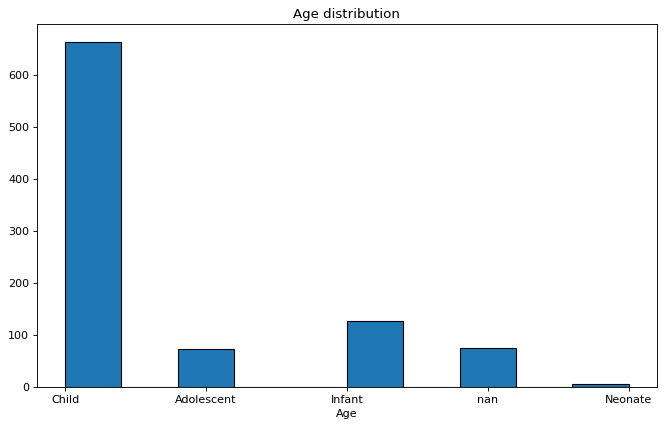

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def create_histogram(data : list, title='', x_label=''):
    plt.figure(figsize=(10, 6), dpi=80)
    
    plt.hist(data,edgecolor="black")
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.show()



create_histogram(
    metadata["Age"],
    "Age distribution",
    "Age",
)




In [8]:
# Recording duration data

files = glob(str(TRAINING_DATA_FOLDER / "*"))

In [9]:
exts = [os.path.splitext(file)[1] for file in files]
print(set(exts))

{'.tsv', '.hea', '.txt', '.wav'}


In [10]:
channels = [os.path.basename(file).split(".")[0] for file in files if file[-3:] == "wav" ]
channels = [match for item in channels for match in re.findall(r'[A-Za-z]+', item)]

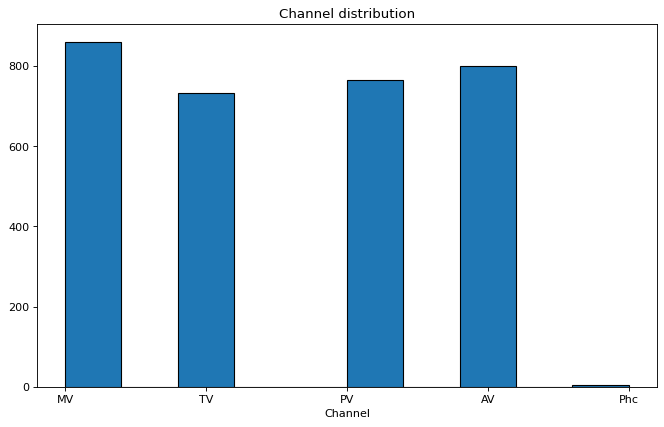

In [11]:
create_histogram(
    channels,
    "Channel distribution",
    "Channel",
)

In [24]:
# Duration Distrubution on time
from pydub import AudioSegment
from tqdm import tqdm
import wfdb

def channels_iterator(folder : Path, channel : str = "AV,TV,MV,PV,Phc", ext : str = ".txt,.wav"):
    return iter(glob( str(folder / f"*{channel}*{ext}") ))

def get_audio_info(audio_file_path : str):
    try:
        audio = AudioSegment.from_file(audio_file_path)
        duration_in_seconds = len(audio) / 1000.0  # Convert to seconds
        sample_rate = audio.frame_rate

        return duration_in_seconds, sample_rate

    except Exception as e:
        print(f"Error: {e}")
        raise e
    
def get_hea_info(hea_file):
    record = wfdb.rdheader(hea_file[:-4])
    duration = record.sig_len / record.fs  # Calculate duration in seconds
    sample_rate = record.fs
    return duration, sample_rate

800it [00:00, 964.33it/s] 


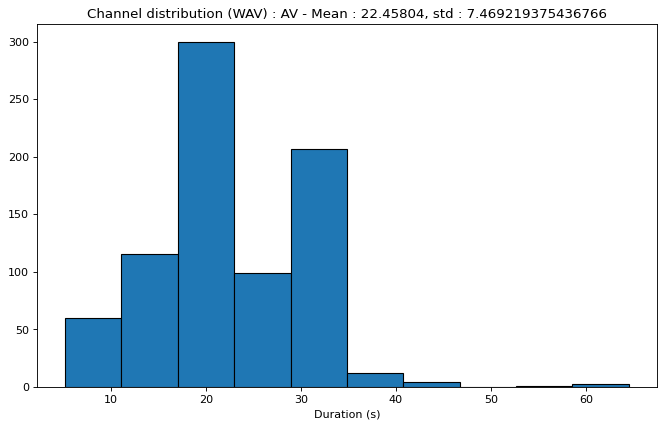

4it [00:00, 439.23it/s]


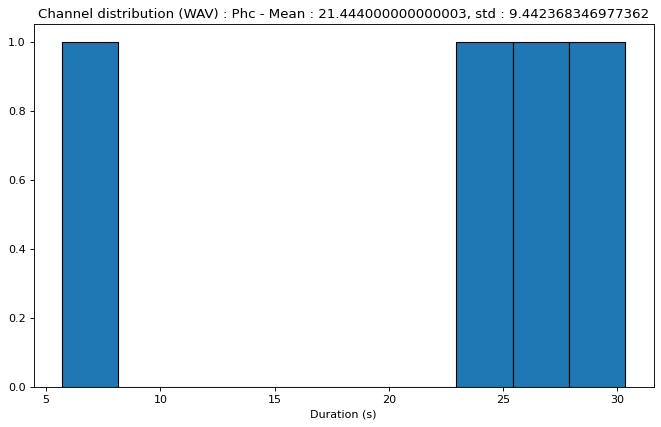

766it [00:01, 584.60it/s]


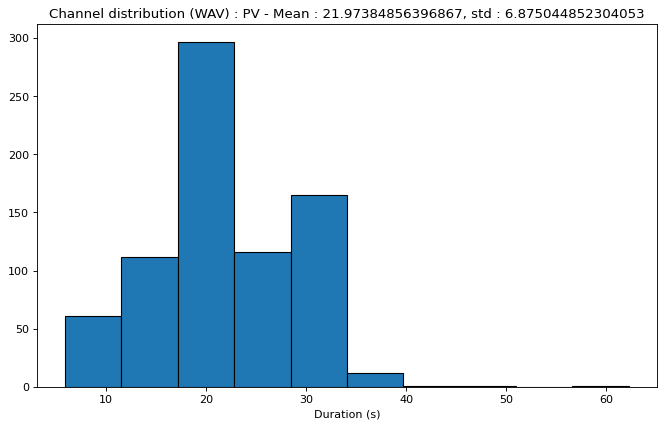

732it [00:01, 559.74it/s]


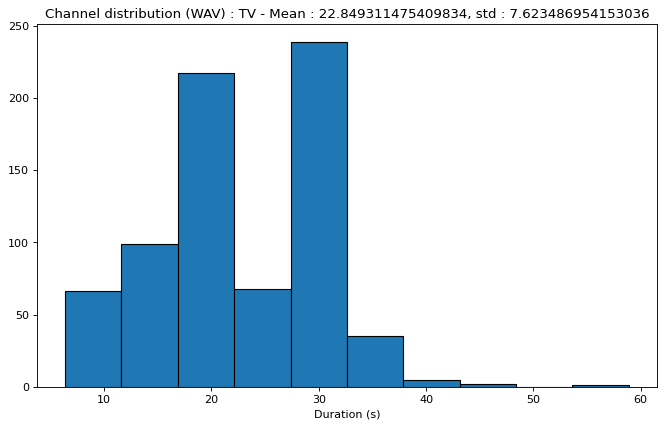

861it [00:01, 564.52it/s]


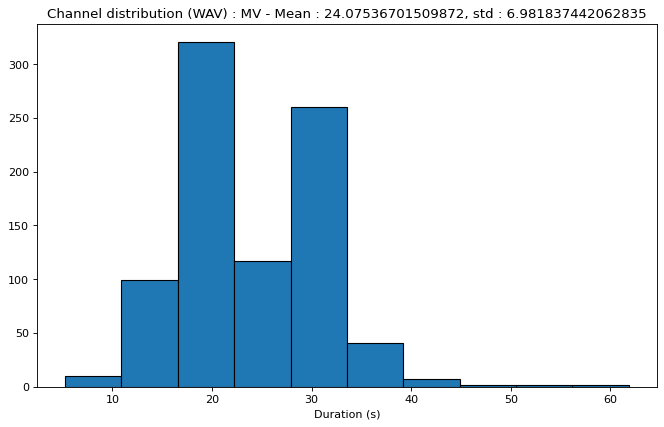

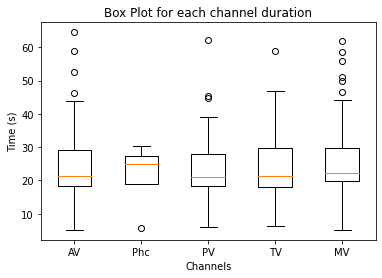

In [32]:
box_plot_durations = []
my_channels = list(set(channels))
for channel in my_channels:
    
    durations = []
    # 2 checking, 
    # one is on the wav files -> audio
    for file in tqdm(channels_iterator(TRAINING_DATA_FOLDER, channel, ".wav")):
        secs, samp_rate = get_audio_info(file)
        durations.append(secs)
        
    mean, std = np.mean(durations), np.std(durations)
        
    create_histogram(
        durations,
        f"Channel distribution (WAV) : {channel} - Mean : {mean}, std : {std}",
        f"Duration (s)",
    )
    box_plot_durations.append(durations)
    continue
    
    
    durations = []
    # second is hea file check -> header detail
    for file in tqdm(channels_iterator(TRAINING_DATA_FOLDER, channel, ".hea")):
        secs, samp_rate = get_hea_info(file)
        durations.append(secs)
        
    mean, std = np.mean(durations), np.std(durations)
        
    create_histogram(
        durations,
        f"Channel distribution (HEA) : {channel} - Mean : {mean}, std : {std}",
        f"Duration (s)",
    )
    
    
    
plt.boxplot(box_plot_durations, labels = my_channels)
plt.title('Box Plot for each channel duration')
plt.xlabel('Channels')
plt.ylabel('Time (s)')

plt.show()
    
        
    
        
        
        

In [ ]:
# For each age group check murmur exist, unknow, not exist


In [104]:
# Annotations Analysis:

# Explore timing, shape, pitch, grading, quality, and location of murmurs.



data = pd.read_csv(DATASET_FOLDER / "training_data.csv")


In [101]:
set(list(data['Diastolic murmur timing']))

{'Early-diastolic', nan}

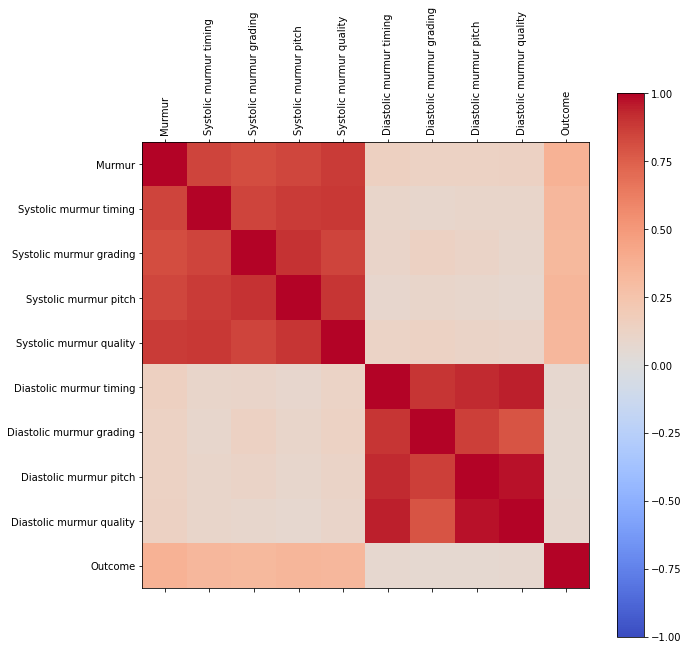

In [105]:
mappings = {
    'Murmur': {"Present": 1, "Absent": -1, "Unknown": 0, np.nan: 0},
#     'Murmur locations': {"PV": 1, "TV": 2, "AV": 3, "MV": 4, "Phc": 5, "Unknown": 0, np.nan: 0},
#     'Most audible location': {"PV": 1, "TV": 2, "AV": 3, "MV": 4, "Phc": 5, "Unknown": 0, np.nan: 0},
    'Systolic murmur timing': {"Early-systolic": 1, "Holosystolic": 2, "Late-systolic": 3, "Mid-systolic": 4, "Unknown": 0, np.nan: 0},
#     'Systolic murmur shape': {"Crescendo": 1, "Decrescendo": 2, "Diamond": 3, "Plateau": 4, "Unknown": 0, np.nan: 0},
    'Systolic murmur grading': {"I/VI": 1, "II/VI": 2, "III/VI": 3, "Unknown": 0, np.nan: 0},
    'Systolic murmur pitch': {"Low": 1, "Medium": 2, "High": 3, "Unknown": 0, np.nan: 0},
    'Systolic murmur quality': {"Blowing": 1, "Harsh": 2, "Musical": 3, "Unknown": 0, np.nan: 0},
    'Diastolic murmur timing': {"Early-diastolic": 1, "Holodiastolic": 2, "Mid-diastolic": 3, np.nan: 0},
#     'Diastolic murmur shape': {"Decrescendo": 1, "Plateau": 2, "Unknown": 0, np.nan: 0},
    'Diastolic murmur grading': {"I/IV": 1, "II/IV": 2, "III/IV": 3, "Unknown": 0, np.nan: 0},
    'Diastolic murmur pitch': {"Low": 1, "Medium": 2, "High": 3, "Unknown": 0, np.nan: 0},
    'Diastolic murmur quality': {"Blowing": 1, "Harsh": 2, "Unknown": 0, np.nan: 0},
    "Outcome": {"Normal": 0, "Abnormal": 1, np.nan: 0}
}

all_fields = list(mappings.keys())




for column, mapping in mappings.items():
    data[column] = data[column].map(mapping)

    
# Calculate the correlation matrix for the selected columns
correlation_matrix = data[all_fields].corr()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Create the correlation matrix heatmap
cax = ax.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

# Set the x and y tick labels
ax.set_xticks(range(len(all_fields)))
ax.set_yticks(range(len(all_fields)))
ax.set_xticklabels(all_fields, rotation=90)
ax.set_yticklabels(all_fields)

# Add a colorbar
fig.colorbar(cax)

# Show the plot
plt.show()




In [89]:
data["Diastolic murmur timing"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
937   NaN
938   NaN
939   NaN
940   NaN
941   NaN
Name: Diastolic murmur timing, Length: 942, dtype: float64

In [39]:
import gc

In [65]:
gc.collect()

6700

In [70]:
data["Murmur"]

0       Absent
1      Present
2      Unknown
3      Present
4      Present
        ...   
937     Absent
938     Absent
939    Present
940     Absent
941     Absent
Name: Murmur, Length: 942, dtype: object